<a href="https://colab.research.google.com/github/goodmorninc-md/CVprojects/blob/main/pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [129]:
import torch
torch.__version__

'2.2.1+cu121'

####准备数据

In [130]:
# y= 0.7 *x + 0.3 (一系列散点)
weight = 0.7
bias = 0.3

#Create Data
start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step)

In [131]:
X


tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000, 0.1200, 0.1400, 0.1600,
        0.1800, 0.2000, 0.2200, 0.2400, 0.2600, 0.2800, 0.3000, 0.3200, 0.3400,
        0.3600, 0.3800, 0.4000, 0.4200, 0.4400, 0.4600, 0.4800, 0.5000, 0.5200,
        0.5400, 0.5600, 0.5800, 0.6000, 0.6200, 0.6400, 0.6600, 0.6800, 0.7000,
        0.7200, 0.7400, 0.7600, 0.7800, 0.8000, 0.8200, 0.8400, 0.8600, 0.8800,
        0.9000, 0.9200, 0.9400, 0.9600, 0.9800])

In [132]:
Y = weight *X + bias
Y

tensor([0.3000, 0.3140, 0.3280, 0.3420, 0.3560, 0.3700, 0.3840, 0.3980, 0.4120,
        0.4260, 0.4400, 0.4540, 0.4680, 0.4820, 0.4960, 0.5100, 0.5240, 0.5380,
        0.5520, 0.5660, 0.5800, 0.5940, 0.6080, 0.6220, 0.6360, 0.6500, 0.6640,
        0.6780, 0.6920, 0.7060, 0.7200, 0.7340, 0.7480, 0.7620, 0.7760, 0.7900,
        0.8040, 0.8180, 0.8320, 0.8460, 0.8600, 0.8740, 0.8880, 0.9020, 0.9160,
        0.9300, 0.9440, 0.9580, 0.9720, 0.9860])

In [133]:
print(X[:10])
print(Y[:10])

tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000, 0.1200, 0.1400, 0.1600,
        0.1800])
tensor([0.3000, 0.3140, 0.3280, 0.3420, 0.3560, 0.3700, 0.3840, 0.3980, 0.4120,
        0.4260])


###划分数据集

In [134]:
# train/test split
#切片是左闭右开，在train_split位置不会相交
train_split = int(len(X)*0.8)
X_train,Y_train = X[:train_split],Y[:train_split]
X_test,Y_test = X[train_split:],Y[train_split:]
len(X_train),len(Y_train)

(40, 40)

###可视化

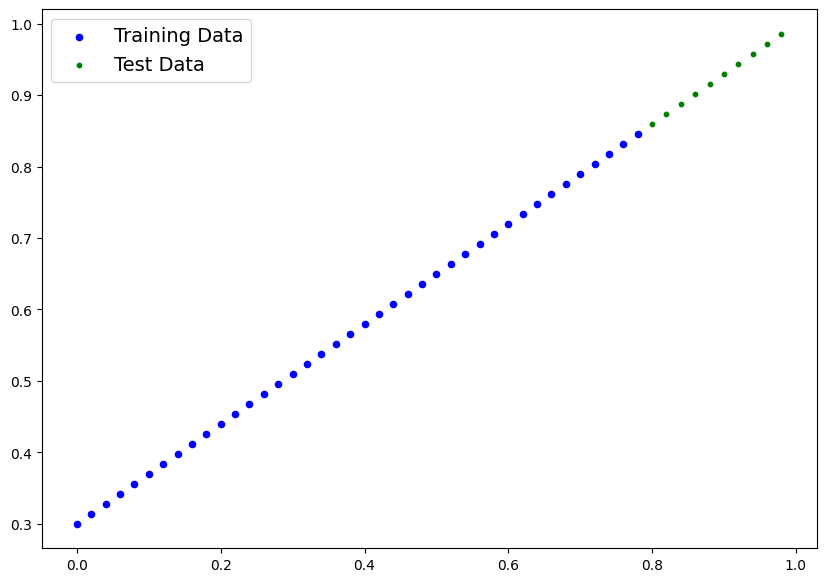

In [135]:
from pickle import NONE
import matplotlib.pyplot as plt
def plot_predictions(train_data = X_train , train_labels = Y_train , test_data = X_test , test_labels = Y_test,predictions = NONE):
  plt.figure(figsize = (10,7))
  #c为散点的颜色，s为散点的大小
  plt.scatter(train_data,train_labels,c="b",s=20,label = "Training Data")
  plt.scatter(test_data,test_labels,c="g",s=10,label="Test Data")

  if predictions is not NONE:
    plt.scatter(test_data,predictions,c="r",s=15,label="Prediction")
  #图例大小字体为14
  plt.legend(prop={
      "size":14
  })
plot_predictions()

##建立模型

  因将test_data视为不知道标签的数据，所以要用模型计算train_data的predictions，然后跟原来已知的labels做比较，然后将训练好的模型/调整好的参数来预测test_labels，就叫做用经验误差来尽可能模拟泛化误差

In [136]:
from torch import nn

In [137]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    #因为要进行梯度求导，所以要require_grad = True
    #
    self.weights = nn.Parameter(torch.randn(1,dtype = torch.float),requires_grad = True)
    self.bias = nn.Parameter(torch.randn(1,dtype = torch.float),requires_grad =True)

  #x类型最好是torch.tensor，但具体没用
  def forward(self,x:torch.tensor):
    return self.weights * x +self.bias

In [138]:
#结果可复现性
torch.manual_seed(666)

model_0 = LinearRegressionModel()
#想打印一个东西，打印出了类似<generator object Module.parameter>的
#强制类型转换为list
model_0.parameters()
list(model_0.parameters())
print(list(model_0.parameters()))

[Parameter containing:
tensor([-2.1188], requires_grad=True), Parameter containing:
tensor([0.0635], requires_grad=True)]


In [139]:
#同样是打印model_0的属性
model_0.state_dict()

OrderedDict([('weights', tensor([-2.1188])), ('bias', tensor([0.0635]))])

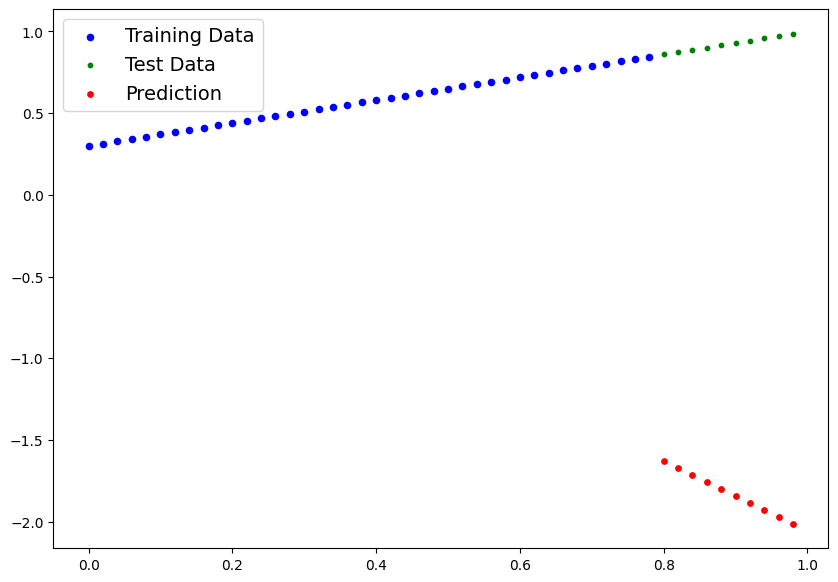

In [140]:
#测试时选择最好的状态，不需要回传 不会对参数进行更新
with torch.inference_mode(): #torch.no_grad()
  y_preds = model_0(X_test)

plot_predictions(predictions = y_preds)

##训练模型
###loss fucntion
**损失函数度量y_pred和y_test之间的差距**
MAE 绝对值/n 3 4 5;2 6 4 = 1.33
MSE 平方/n 3 4 5;2 6 4 = 2
###optimizer
**告诉模型怎样朝着正确的参数走过去**

In [141]:
loss_fn = nn.L1Loss() #MAE
#SGD 随机梯度下降 lr:learning rate
optimizer = torch.optim.SGD(params = model_0.parameters(),lr = 0.1)


##Trining loop


In [142]:
torch.manual_seed(666)
epochs = 100

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
  #put model in training mode,进入训练模式
  model_0.train()

  #1.forward pass,using forward function
  #得到的是训练集的y_pred
  y_pred = model_0(X_train)

  #2.calculate Loss
  loss= loss_fn(y_pred,Y_train)

  #3.Zero_grad 防止之前的梯度对当前步产生影响
  optimizer.zero_grad()

  #4.back prop
  loss.backward()

  #5.progress optimizer
  optimizer.step()

  model_0.eval()
  #进入infer模式，看当前训练的参数对于训练集的效果
  with torch.inference_mode():
    test_pred = model_0(X_test)
    test_loss = loss_fn(test_pred,Y_test.type(torch.float))
    epoch_count.append(epoch)
    train_loss_values.append(loss.detach().numpy())
    test_loss_values.append(test_loss.detach().numpy())

    print(f"Epoch:{epoch} | Train Loss:{loss} | Test Loss:{test_loss}")

Epoch:0 | Train Loss:1.3358044624328613 | Test Loss:2.610489845275879
Epoch:1 | Train Loss:1.2205944061279297 | Test Loss:2.4757800102233887
Epoch:2 | Train Loss:1.1053844690322876 | Test Loss:2.3410699367523193
Epoch:3 | Train Loss:0.9938250780105591 | Test Loss:2.216449022293091
Epoch:4 | Train Loss:0.9000433683395386 | Test Loss:2.097005844116211
Epoch:5 | Train Loss:0.8182994723320007 | Test Loss:1.9881856441497803
Epoch:6 | Train Loss:0.7505138516426086 | Test Loss:1.8903448581695557
Epoch:7 | Train Loss:0.6957289576530457 | Test Loss:1.7981269359588623
Epoch:8 | Train Loss:0.6484459638595581 | Test Loss:1.7116206884384155
Epoch:9 | Train Loss:0.6080412864685059 | Test Loss:1.630915880203247
Epoch:10 | Train Loss:0.5741841197013855 | Test Loss:1.562079668045044
Epoch:11 | Train Loss:0.5479332804679871 | Test Loss:1.4993116855621338
Epoch:12 | Train Loss:0.5259488821029663 | Test Loss:1.4365437030792236
Epoch:13 | Train Loss:0.5061115026473999 | Test Loss:1.3799326419830322
Epoch:1

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[array(1.3358045, dtype=float32), array(1.2205944, dtype=float32), array(1.1053845, dtype=float32), array(0.9938251, dtype=float32), array(0.90004337, dtype=float32), array(0.8182995, dtype=float32), array(0.75051385, dtype=float32), array(0.69572896, dtype=float32), array(0.64844596, dtype=float32), array(0.6080413, dtype=float32), array(0.5741841, dtype=float32), array(0.5479333, dtype=float32), array(0.5259489, dtype=float32), array(0.5061115, dtype=float32), array(0.48988876, dtype=float32), array(0.47659263, dtype=float32), array(0.465521, dtype=float32), array(0.45681944, dtype=float32), array(0.

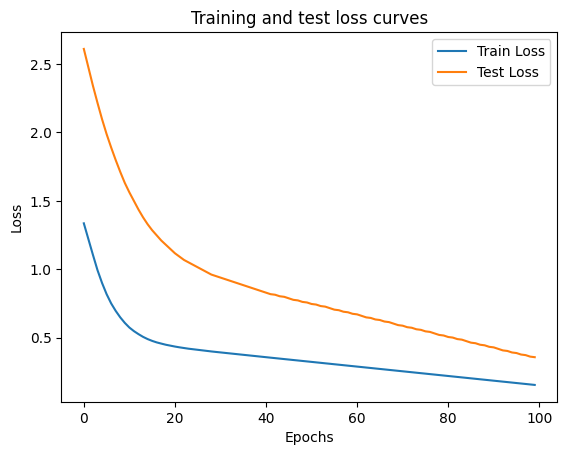

In [143]:
print(epoch_count)
print(train_loss_values)

plt.plot(epoch_count, train_loss_values, label = "Train Loss")
plt.plot(epoch_count, test_loss_values, label = "Test Loss")

plt.title("Training and test loss curves")

plt.ylabel("Loss")
plt.xlabel("Epochs")

plt.legend()

##训练模型后 ，尝试在测试集上做测试

##假设已经训练好模型


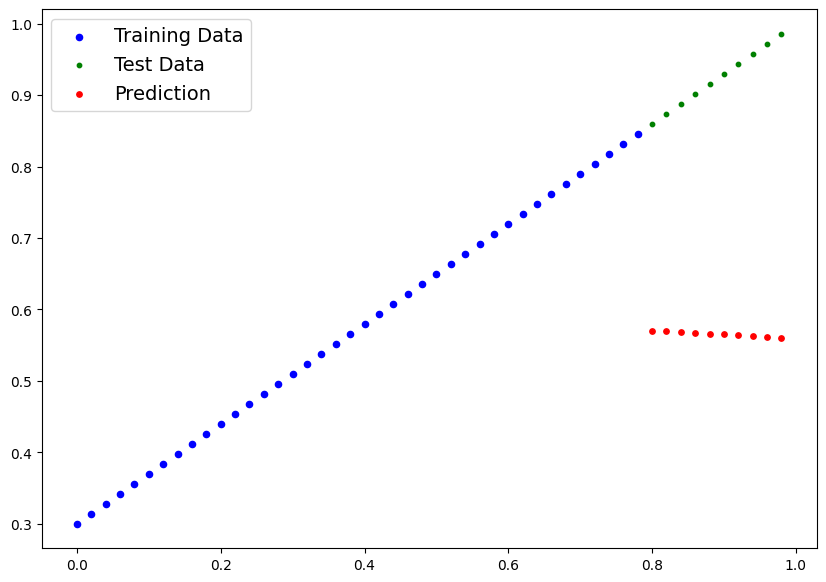

In [144]:
#测试时选择最好的状态，不需要回传
model_0.eval()
with torch.inference_mode(): #torch.no_grad()
  y_preds = model_0(X_test)

plot_predictions(predictions = y_preds)

In [145]:
model_0.state_dict()


OrderedDict([('weights', tensor([-0.0539])), ('bias', tensor([0.6135]))])

##保存模型


In [147]:
from pathlib import Path
MODEL_PATH =Path("models")

MODEL_PATH.mkdir(parents = True,exist_ok = True)

MODEL_NAME = "02_pytorch_workflow_model_0.pth"

MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME
MODEL_SAVE_PATH

PosixPath('models/02_pytorch_workflow_model_0.pth')

In [148]:
#保存模型
torch.save(obj = model_0.state_dict(), f= MODEL_SAVE_PATH)

In [150]:
loaded_model_0 = LinearRegressionModel()
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([-1.4555])), ('bias', tensor([-0.0126]))])

In [151]:
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([-0.0539])), ('bias', tensor([0.6135]))])